In [1]:
import sys
import os

local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')

In [2]:
from datetime import datetime
start_time = datetime.now() # initialize timer
import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as op
import astropy.units as u
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import emcee



In [3]:
import MulensModel as mm
from MulensModel.utils import Utils
import mcmcFit as mcfit

In [4]:

#reading in data and loading it as arrays 

from glob import glob
im_dir = '/Users/adrianhernandez/JPL_2021/ukirt_psf/'
ukirt_file = glob(f"{im_dir}/*P71224*.txt")

#print(ukirt_file[2])

filename = ukirt_file[2][44:64]
ukirt_data_H = np.loadtxt(ukirt_file[0], usecols=range(3)) #H band data 
ukirt_data_K = np.loadtxt(ukirt_file[2], usecols=range(3)) # K band data 
H_data = mm.MulensData(file_name=ukirt_file[0]) #used only for the mulens code 
K_data = mm.MulensData(file_name=ukirt_file[2]) #used only for the mulens code
print(filename)

data = np.concatenate((ukirt_data_H,ukirt_data_K)) # combining both bands
print(len(data))

2019_c2_4_4_H_P71224
645


In [5]:
# ***Set time range of planetary perturbation (including 2450000).***
(t_planet_start, t_planet_stop) = (2458660.,2458690.)

# ***Set time range of planetary perturbation (including 2450000).***

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [0, 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2459000.]

chi2: 2721.047351672527
Planetary Guesses
    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2458654.00000  0.030000    50.0000 0.01000   0.89518   0.08000000   105.46500 



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/MulensModel-1.17.15-py3.8-macosx-10.9-x86_64.egg/MulensModel/model.py:453: FutureWarning: Keyword "color_list" is deprecated. Use MulensData.plot_properties instead.
  warnings.warn('Keyword "' + old_keyword + '" is deprecated.' +
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/MulensModel-1.17.15-py3.8-macosx-10.9-x86_64.egg/MulensModel/model.py:453: FutureWarning: Keyword "label_list" is deprecated. Use MulensData.plot_properties instead.
  warnings.warn('Keyword "' + old_keyword + '" is deprecated.' +


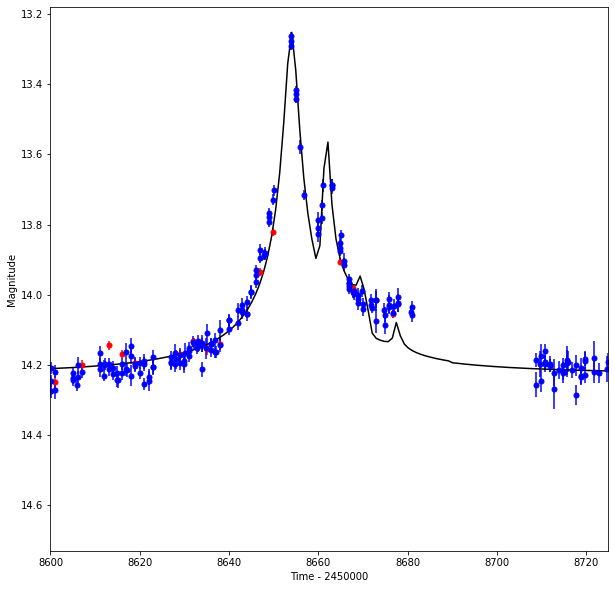

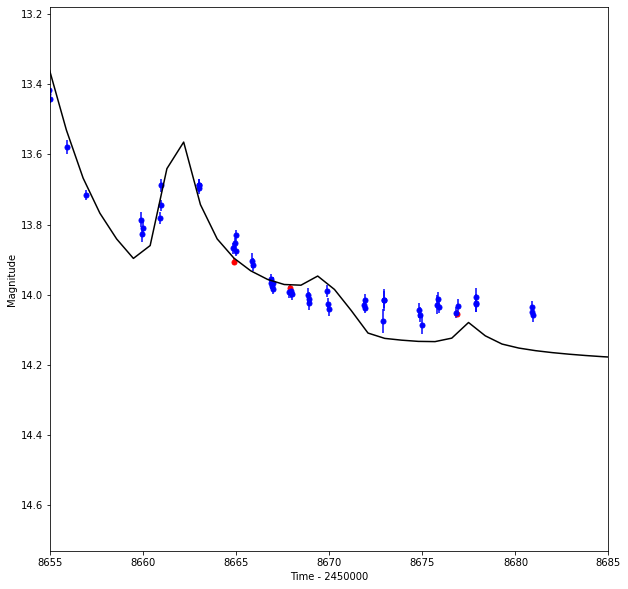

In [6]:
# Look at the planetary moodel with inital guesses
#Try s_plus & s_minus

refine_model = mm.Model({'t_0': 2458654, 
                         'u_0': .03 , 
                         't_E': 50.,
                         'rho': 10**(-2),
                         's': 0.89518,
                         'q': 8*10**(-2),
                         'alpha': 105.46500})
refine_model.set_magnification_methods(magnification_methods)
refine_event = mm.Event(datasets=[H_data,K_data], model=refine_model)

print('chi2: {0}'.format(refine_event.get_chi2()))

print('Planetary Guesses')
print(refine_model)

# Plot (excluded data shown as 'X')
pl.figure(figsize=(10,10))
refine_event.plot_data(subtract_2450000=True, color_list=['blue', 'red'],label_list= ['H_band','K_band'],  s=5)
refine_event.plot_model(t_range=[2457900,2458800], subtract_2450000=True, color='black')

pl.xlim(8600,8725)
pl.show()

pl.figure(figsize=(10,10))
refine_event.plot_data(show_bad=True, subtract_2450000=True)
refine_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black', zorder=10)
pl.xlim(8655,8685)
pl.show()

In [7]:
print(refine_event.model.parameters.t_0)
print(refine_event.model.parameters.t_E)
print(refine_event.model.parameters.u_0)
print(refine_event.model.parameters.rho)

2458654
50.0
0.03
0.01


In [8]:
## np.set_printoptions(threshold=sys.maxsize)

#Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf 
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2(fit_blending = True)

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

In [9]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.005
delta_log_q = 0.06
# grid_log_s = np.hstack(
#     (np.arange(
#         np.log10(s_minus) - 0.1, np.log10(s_minus) + 0.1, delta_log_s),
#     np.arange(
#         np.log10(s_plus) - 0.1, np.log10(s_plus) + 0.1, delta_log_s)))
grid_log_s = np.arange(np.log10(0.60),np.log10(.999999),delta_log_s)
grid_log_q = np.arange(-5, -1, delta_log_q)

print(grid_log_s)
print(grid_log_q)

[-0.22184875 -0.21684875 -0.21184875 -0.20684875 -0.20184875 -0.19684875
 -0.19184875 -0.18684875 -0.18184875 -0.17684875 -0.17184875 -0.16684875
 -0.16184875 -0.15684875 -0.15184875 -0.14684875 -0.14184875 -0.13684875
 -0.13184875 -0.12684875 -0.12184875 -0.11684875 -0.11184875 -0.10684875
 -0.10184875 -0.09684875 -0.09184875 -0.08684875 -0.08184875 -0.07684875
 -0.07184875 -0.06684875 -0.06184875 -0.05684875 -0.05184875 -0.04684875
 -0.04184875 -0.03684875 -0.03184875 -0.02684875 -0.02184875 -0.01684875
 -0.01184875 -0.00684875 -0.00184875]
[-5.   -4.94 -4.88 -4.82 -4.76 -4.7  -4.64 -4.58 -4.52 -4.46 -4.4  -4.34
 -4.28 -4.22 -4.16 -4.1  -4.04 -3.98 -3.92 -3.86 -3.8  -3.74 -3.68 -3.62
 -3.56 -3.5  -3.44 -3.38 -3.32 -3.26 -3.2  -3.14 -3.08 -3.02 -2.96 -2.9
 -2.84 -2.78 -2.72 -2.66 -2.6  -2.54 -2.48 -2.42 -2.36 -2.3  -2.24 -2.18
 -2.12 -2.06 -2.   -1.94 -1.88 -1.82 -1.76 -1.7  -1.64 -1.58 -1.52 -1.46
 -1.4  -1.34 -1.28 -1.22 -1.16 -1.1  -1.04]


In [10]:
alpha_new = -9.0

In [11]:

# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_new + 180
        else:
            alpha = alpha_new 
            
        # Define the Model and Event
        fit_planet_model = mm.Model({
            't_0': refine_event.model.parameters.t_0, 
            'u_0': refine_event.model.parameters.u_0,
            't_E': refine_event.model.parameters.t_E,
            'rho': 10**(-2),
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha_new})
        fit_planet_model.set_magnification_methods(magnification_methods)
        fit_planet_event = mm.Event(datasets = [H_data,K_data], model=fit_planet_model)
            
        # Fit the Event
        result = fit_model(fit_planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = fit_planet_event.get_chi2()
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            fit_planet_event.model.parameters.alpha, fit_planet_event.model.parameters.rho))
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = fit_planet_event.model.parameters.alpha.value
        grid[4, i] = fit_planet_event.model.parameters.rho
            
        i += 1

        chi2      s       q   alpha     rho
     4581.50 0.6000 0.00001   23.39 deg 0.23988
     4581.50 0.6000 0.00001   23.37 deg 0.23988
     4581.50 0.6000 0.00001   23.37 deg 0.23988
     4581.50 0.6000 0.00002   23.37 deg 0.23988
     4581.50 0.6000 0.00002   23.37 deg 0.23988
     4581.50 0.6000 0.00002   23.37 deg 0.23988
     4581.51 0.6000 0.00002   23.37 deg 0.23988
     4581.51 0.6000 0.00003   23.41 deg 0.23991
     4581.51 0.6000 0.00003   23.41 deg 0.23991
     4581.51 0.6000 0.00003   22.67 deg 0.23988
     4581.51 0.6000 0.00004   23.01 deg 0.23988
     4581.51 0.6000 0.00005   22.10 deg 0.23986
     4581.51 0.6000 0.00005   22.12 deg 0.23988
     4581.51 0.6000 0.00006   23.02 deg 0.23989
     4581.52 0.6000 0.00007   23.00 deg 0.23989
     4581.52 0.6000 0.00008   22.99 deg 0.23989
     4581.52 0.6000 0.00009   23.33 deg 0.23989
     4581.52 0.6000 0.00010   22.30 deg 0.23991
     4581.53 0.6000 0.00012   23.34 deg 0.23991
     4581.53 0.6000 0.00014   23.22 deg 0.23

     4581.24 0.6140 0.00145    1.83 deg 0.23997
     4581.20 0.6140 0.00166    0.31 deg 0.24007
     4581.16 0.6140 0.00191    1.95 deg 0.24011
     4581.11 0.6140 0.00219    1.88 deg 0.24013
     4581.06 0.6140 0.00251   -0.95 deg 0.24023
     4581.01 0.6140 0.00288   -0.14 deg 0.24022
     4580.95 0.6140 0.00331    0.34 deg 0.24023
     4580.89 0.6140 0.00380    0.20 deg 0.24041
     4580.83 0.6140 0.00437   -1.28 deg 0.24041
     4580.77 0.6140 0.00501   -0.69 deg 0.24053
     4581.00 0.6140 0.00575   -1.17 deg 0.23578
     4580.79 0.6140 0.00661   -1.14 deg 0.23571
     4580.55 0.6140 0.00759   -0.53 deg 0.23563
     5434.23 0.6140 0.00871   -9.30 deg 0.00000
     5399.11 0.6140 0.01000   -9.34 deg 0.00000
     5358.58 0.6140 0.01148   -9.39 deg 0.00000
     5311.79 0.6140 0.01318   -9.44 deg 0.00000
     5257.76 0.6140 0.01514   -9.50 deg 0.00000
     5195.38 0.6140 0.01738   -9.56 deg 0.00000
     5123.44 0.6140 0.01995   -9.63 deg 0.00000
     5040.59 0.6140 0.02291   -9.71 deg 

     4581.51 0.6356 0.00002   23.39 deg 0.23988
     4581.51 0.6356 0.00003   23.41 deg 0.23991
     4581.51 0.6356 0.00003   23.41 deg 0.23991
     4581.51 0.6356 0.00003   23.39 deg 0.23989
     4581.51 0.6356 0.00004   23.39 deg 0.23989
     4581.51 0.6356 0.00005   23.39 deg 0.23989
     4581.51 0.6356 0.00005   22.97 deg 0.23988
     4581.52 0.6356 0.00006   23.40 deg 0.23992
     4581.51 0.6356 0.00007   22.10 deg 0.23988
     4581.52 0.6356 0.00008   22.99 deg 0.23988
     4581.51 0.6356 0.00009   22.01 deg 0.23988
     4581.51 0.6356 0.00010   21.69 deg 0.23988
     4581.52 0.6356 0.00012   21.67 deg 0.23988
     4581.52 0.6356 0.00014   21.68 deg 0.23989
     4581.52 0.6356 0.00016   22.10 deg 0.23988
     4581.55 0.6356 0.00018   23.44 deg 0.23989
     4581.53 0.6356 0.00021   22.13 deg 0.23990
     4581.54 0.6356 0.00024   22.11 deg 0.23989
     4581.57 0.6356 0.00028   23.23 deg 0.23989
     4581.56 0.6356 0.00032   22.12 deg 0.23989
     4581.57 0.6356 0.00036   22.40 deg 

     4580.58 0.6504 0.00380    0.14 deg 0.24039
     4580.49 0.6504 0.00437   -1.02 deg 0.24052
     4580.59 0.6504 0.00501   -7.00 deg 0.24060
     5464.95 0.6504 0.00575   -9.31 deg 0.00001
     5434.47 0.6504 0.00661   -9.34 deg 0.00000
     5399.26 0.6504 0.00759   -9.38 deg 0.00000
     5358.57 0.6504 0.00871   -9.43 deg 0.00000
     5311.53 0.6504 0.01000   -9.48 deg 0.00000
     5257.12 0.6504 0.01148   -9.54 deg 0.00000
     5194.19 0.6504 0.01318   -9.60 deg 0.00000
     5121.42 0.6504 0.01514   -9.67 deg 0.00000
     5037.40 0.6504 0.01738   -9.75 deg 0.00000
     4940.63 0.6504 0.01995   -9.82 deg 0.00000
     4829.79 0.6504 0.02291   -9.89 deg 0.00000
     4704.09 0.6504 0.02630   -9.93 deg 0.00000
     4563.96 0.6504 0.03020   -9.91 deg 0.00000
     4411.43 0.6504 0.03467   -9.77 deg 0.00000
     4248.21 0.6504 0.03981   -9.53 deg 0.00000
     4072.45 0.6504 0.04571   -9.34 deg 0.00000
     3881.29 0.6504 0.05248   -9.30 deg 0.00000
     3677.15 0.6504 0.06026   -9.41 deg 

     4581.50 0.6732 0.00006   22.11 deg 0.23988
     4581.50 0.6732 0.00007   21.99 deg 0.23987
     4581.50 0.6732 0.00008   21.62 deg 0.23989
     4581.51 0.6732 0.00009   21.62 deg 0.23988
     4581.51 0.6732 0.00010   21.62 deg 0.23988
     4581.51 0.6732 0.00012   22.10 deg 0.23988
     4581.51 0.6732 0.00014   21.44 deg 0.23984
     4581.50 0.6732 0.00016   19.43 deg 0.23989
     4581.54 0.6732 0.00018   23.29 deg 0.23989
     4581.55 0.6732 0.00021   23.28 deg 0.23990
     4581.56 0.6732 0.00024   23.14 deg 0.23993
     4581.56 0.6732 0.00028   23.33 deg 0.23993
     4581.39 0.6732 0.00032    0.41 deg 0.23987
     4581.37 0.6732 0.00036    0.39 deg 0.23994
     4581.35 0.6732 0.00042    0.38 deg 0.23994
     4581.33 0.6732 0.00048    1.98 deg 0.23993
     4581.31 0.6732 0.00055   -2.01 deg 0.24002
     4581.28 0.6732 0.00063   -0.91 deg 0.23997
     4581.25 0.6732 0.00072   -1.42 deg 0.23993
     4581.22 0.6732 0.00083   -0.93 deg 0.23996
     4581.18 0.6732 0.00095   -1.65 deg 

     5185.51 0.6889 0.01000   -9.67 deg 0.00000
     5110.97 0.6889 0.01148   -9.74 deg 0.00000
     5024.75 0.6889 0.01318   -9.81 deg 0.00000
     4925.31 0.6889 0.01514   -9.89 deg 0.00000
     4811.28 0.6889 0.01738   -9.95 deg 0.00000
     4681.90 0.6889 0.01995   -9.98 deg 0.00000
     4537.69 0.6889 0.02291   -9.94 deg 0.00000
     4380.41 0.6889 0.02630   -9.79 deg 0.00000
     4210.37 0.6889 0.03020   -9.60 deg 0.00000
     4024.98 0.6889 0.03467   -9.49 deg 0.00001
     3823.22 0.6889 0.03981   -9.48 deg 0.00233
     3608.61 0.6889 0.04571   -9.29 deg 0.00651
     3382.53 0.6889 0.05248   -9.16 deg 0.00769
     3185.94 0.6889 0.06026   -8.83 deg 0.00854
     3033.94 0.6889 0.06918   -8.20 deg 0.00975
     2936.64 0.6889 0.07943   -7.42 deg 0.01126
     2886.17 0.6889 0.09120   -6.56 deg 0.01417
     4581.50 0.6969 0.00001   23.37 deg 0.23988
     4581.50 0.6969 0.00001   23.37 deg 0.23989
     4581.50 0.6969 0.00001   23.31 deg 0.23988
     4581.51 0.6969 0.00002   23.37 deg 

     4581.51 0.7131 0.00016   21.95 deg 0.23988
     4581.54 0.7131 0.00018   23.28 deg 0.23989
     4581.40 0.7131 0.00021   -0.02 deg 0.23990
     4581.38 0.7131 0.00024    4.90 deg 0.23990
     4581.37 0.7131 0.00028    4.90 deg 0.23991
     4581.35 0.7131 0.00032    2.16 deg 0.23998
     4581.33 0.7131 0.00036    2.75 deg 0.24004
     4581.30 0.7131 0.00042    2.82 deg 0.23993
     4581.28 0.7131 0.00048   -1.65 deg 0.23994
     4581.24 0.7131 0.00055   -1.47 deg 0.23994
     4581.20 0.7131 0.00063   -0.01 deg 0.24000
     4579.28 0.7131 0.00072   -5.64 deg 0.23949
     4581.11 0.7131 0.00083    0.21 deg 0.24003
     4581.06 0.7131 0.00095   -0.40 deg 0.24007
     4580.99 0.7131 0.00110    0.39 deg 0.24003
     4580.92 0.7131 0.00126    0.31 deg 0.24007
     4580.84 0.7131 0.00145    0.15 deg 0.24016
     4580.75 0.7131 0.00166    0.20 deg 0.24010
     4580.97 0.7131 0.00191  -12.28 deg 0.24019
     4580.53 0.7131 0.00219   -0.72 deg 0.24025
     5525.72 0.7131 0.00251   -9.34 deg 

     3958.21 0.7297 0.02630   -9.49 deg 0.00517
     3744.17 0.7297 0.03020   -9.34 deg 0.00686
     3513.60 0.7297 0.03467   -9.25 deg 0.00755
     3288.00 0.7297 0.03981   -8.99 deg 0.00836
     3104.80 0.7297 0.04571   -8.59 deg 0.00912
     2973.28 0.7297 0.05248   -7.90 deg 0.01052
     2901.58 0.7297 0.06026   -7.09 deg 0.01303
     2863.68 0.7297 0.06918   -6.41 deg 0.01706
     2843.30 0.7297 0.07943   -5.98 deg 0.02166
     3183.18 0.7297 0.09120  -10.94 deg 0.00056
     4581.49 0.7382 0.00001   22.12 deg 0.23988
     4581.50 0.7382 0.00001   23.37 deg 0.23988
     4581.50 0.7382 0.00001   23.37 deg 0.23988
     4581.51 0.7382 0.00002   23.38 deg 0.23988
     4581.51 0.7382 0.00002   23.19 deg 0.23989
     4581.51 0.7382 0.00002   23.11 deg 0.23989
     4581.49 0.7382 0.00002   22.13 deg 0.23988
     4581.49 0.7382 0.00003   22.03 deg 0.23987
     4581.49 0.7382 0.00003   22.11 deg 0.23989
     4581.51 0.7382 0.00003   23.11 deg 0.23987
     4581.51 0.7382 0.00004   23.27 deg 

     4581.24 0.7554 0.00042    3.62 deg 0.23998
     4581.20 0.7554 0.00048    0.33 deg 0.24009
     4581.16 0.7554 0.00055   -0.42 deg 0.24000
     4581.11 0.7554 0.00063   -1.08 deg 0.23995
     4581.06 0.7554 0.00072    1.09 deg 0.24003
     4580.99 0.7554 0.00083    0.68 deg 0.24002
     4580.91 0.7554 0.00095    0.15 deg 0.24014
     4578.61 0.7554 0.00110   -4.81 deg 0.23963
     4580.99 0.7554 0.00126   12.85 deg 0.24005
     5554.20 0.7554 0.00145   -9.40 deg 0.00000
     5537.38 0.7554 0.00166   -9.41 deg 0.00000
     5517.99 0.7554 0.00191   -9.44 deg 0.00000
     5495.62 0.7554 0.00219   -9.46 deg 0.00000
     5469.79 0.7554 0.00251   -9.49 deg 0.00000
     5439.95 0.7554 0.00288   -9.53 deg 0.00000
     5405.45 0.7554 0.00331   -9.57 deg 0.00000
     5365.54 0.7554 0.00380   -9.61 deg 0.00000
     5319.33 0.7554 0.00437   -9.66 deg 0.00000
     5265.79 0.7554 0.00501   -9.72 deg 0.00000
     5203.74 0.7554 0.00575   -9.78 deg 0.00000
     5131.84 0.7554 0.00661   -9.85 deg 

     2849.42 0.7729 0.06918   -7.50 deg 0.02961
     3059.90 0.7729 0.07943  -11.49 deg 0.01539
     2934.23 0.7729 0.09120   -9.99 deg 0.00633
     4581.52 0.7819 0.00001  -49.68 deg 0.23985
     4581.52 0.7819 0.00001  -49.69 deg 0.23988
     4581.53 0.7819 0.00001  -49.75 deg 0.23988
     4581.53 0.7819 0.00002  -49.45 deg 0.23988
     4581.53 0.7819 0.00002  -49.47 deg 0.23988
     4581.54 0.7819 0.00002  -49.78 deg 0.23988
     4581.54 0.7819 0.00002  -49.48 deg 0.23988
     4581.55 0.7819 0.00003  -49.67 deg 0.23988
     4581.55 0.7819 0.00003  -49.72 deg 0.23988
     4581.56 0.7819 0.00003  -49.75 deg 0.23987
     4581.57 0.7819 0.00004  -49.81 deg 0.23987
     4581.58 0.7819 0.00005  -49.81 deg 0.23987
     4581.59 0.7819 0.00005  -49.63 deg 0.23989
     4581.61 0.7819 0.00006  -49.64 deg 0.23990
     4581.62 0.7819 0.00007  -49.64 deg 0.23989
     4581.64 0.7819 0.00008  -49.48 deg 0.23988
     4581.66 0.7819 0.00009  -49.62 deg 0.23987
     4581.42 0.7819 0.00010    0.18 deg 

     5543.78 0.8001 0.00110   -9.53 deg 0.00000
     5525.37 0.8001 0.00126   -9.55 deg 0.00000
     5504.14 0.8001 0.00145   -9.57 deg 0.00000
     5479.63 0.8001 0.00166   -9.60 deg 0.00000
     5451.33 0.8001 0.00191   -9.63 deg 0.00000
     5418.63 0.8001 0.00219   -9.67 deg 0.00000
     5380.80 0.8001 0.00251   -9.71 deg 0.00000
     5337.04 0.8001 0.00288   -9.76 deg 0.00000
     5286.36 0.8001 0.00331   -9.82 deg 0.00000
     5227.67 0.8001 0.00380   -9.88 deg 0.00000
     5159.72 0.8001 0.00437   -9.94 deg 0.00000
     5081.11 0.8001 0.00501  -10.02 deg 0.00000
     4990.40 0.8001 0.00575  -10.09 deg 0.00000
     4886.30 0.8001 0.00661  -10.16 deg 0.00000
     4767.96 0.8001 0.00759  -10.19 deg 0.00000
     4635.48 0.8001 0.00871  -10.18 deg 0.00000
     4489.68 0.8001 0.01000  -10.10 deg 0.00001
     4327.61 0.8001 0.01148   -9.85 deg 0.00509
     4144.81 0.8001 0.01318   -9.64 deg 0.00668
     3940.58 0.8001 0.01514   -9.46 deg 0.00747
     3715.92 0.8001 0.01738   -9.33 deg 

     4581.54 0.8282 0.00002  -49.76 deg 0.23988
     4581.54 0.8282 0.00002  -49.48 deg 0.23988
     4581.55 0.8282 0.00002  -49.49 deg 0.23988
     4581.55 0.8282 0.00003  -49.67 deg 0.23988
     4581.56 0.8282 0.00003  -49.80 deg 0.23989
     4581.57 0.8282 0.00003  -49.63 deg 0.23988
     4581.58 0.8282 0.00004  -49.72 deg 0.23990
     4581.59 0.8282 0.00005  -49.61 deg 0.23990
     4581.60 0.8282 0.00005  -47.75 deg 0.23987
     4581.61 0.8282 0.00006  -47.44 deg 0.23989
     4581.63 0.8282 0.00007  -48.46 deg 0.23993
     4581.65 0.8282 0.00008  -47.32 deg 0.23988
     4581.41 0.8282 0.00009    0.33 deg 0.23989
     4581.39 0.8282 0.00010    2.98 deg 0.23991
     4581.43 0.8282 0.00012  -14.09 deg 0.23991
     4581.37 0.8282 0.00014    0.61 deg 0.23991
     4581.35 0.8282 0.00016    0.52 deg 0.23990
     4581.41 0.8282 0.00018  -17.15 deg 0.23990
     4581.39 0.8282 0.00021  -16.78 deg 0.23992
     4581.31 0.8282 0.00024   10.13 deg 0.23991
     4581.26 0.8282 0.00028    7.36 deg 

     5162.42 0.8475 0.00288  -10.12 deg 0.00000
     5085.04 0.8475 0.00331  -10.19 deg 0.00000
     4996.25 0.8475 0.00380  -10.27 deg 0.00000
     4895.14 0.8475 0.00437  -10.32 deg 0.00000
     4781.47 0.8475 0.00501  -10.35 deg 0.00000
     4655.74 0.8475 0.00575  -10.26 deg 0.00250
     4513.62 0.8475 0.00661  -10.04 deg 0.00533
     4351.71 0.8475 0.00759   -9.83 deg 0.00670
     4168.59 0.8475 0.00871   -9.65 deg 0.00746
     3963.88 0.8475 0.01000   -9.49 deg 0.00778
     3740.87 0.8475 0.01148   -9.35 deg 0.00787
     3514.98 0.8475 0.01318   -9.19 deg 0.00834
     3310.13 0.8475 0.01514   -9.03 deg 0.00857
     3121.42 0.8475 0.01738   -8.66 deg 0.00889
     2997.30 0.8475 0.01995   -8.14 deg 0.01029
     2934.85 0.8475 0.02291   -7.72 deg 0.01312
     2903.91 0.8475 0.02630   -7.62 deg 0.01653
     2891.55 0.8475 0.03020   -7.91 deg 0.02004
     2891.23 0.8475 0.03467   -8.47 deg 0.02335
     3134.51 0.8475 0.03981  -10.52 deg 0.01156
     3174.70 0.8475 0.04571  -10.14 deg 

     4581.60 0.8773 0.00005  -49.30 deg 0.23989
     4581.61 0.8773 0.00005  -49.27 deg 0.23989
     4581.62 0.8773 0.00006  -48.87 deg 0.23990
     4581.64 0.8773 0.00007  -49.25 deg 0.23989
     4581.67 0.8773 0.00008  -49.31 deg 0.23989
     4581.44 0.8773 0.00009  -17.58 deg 0.23993
     4581.43 0.8773 0.00010  -17.53 deg 0.23990
     4581.42 0.8773 0.00012  -16.66 deg 0.23984
     4581.35 0.8773 0.00014    7.11 deg 0.23990
     4581.33 0.8773 0.00016    7.06 deg 0.23989
     4581.30 0.8773 0.00018   -0.76 deg 0.23992
     4581.28 0.8773 0.00021   -4.23 deg 0.23991
     5612.80 0.8773 0.00024   -9.75 deg 0.00001
     5604.89 0.8773 0.00028   -9.76 deg 0.00000
     5595.78 0.8773 0.00032   -9.77 deg 0.00000
     5585.30 0.8773 0.00036   -9.78 deg 0.00000
     5573.25 0.8773 0.00042   -9.80 deg 0.00000
     5559.36 0.8773 0.00048   -9.82 deg 0.00000
     5543.38 0.8773 0.00055   -9.84 deg 0.00000
     5524.95 0.8773 0.00063   -9.86 deg 0.00000
     5503.72 0.8773 0.00072   -9.88 deg 

     3696.01 0.8977 0.00759   -9.28 deg 0.00843
     3500.73 0.8977 0.00871   -9.18 deg 0.00840
     3288.47 0.8977 0.01000   -8.91 deg 0.00806
     3117.15 0.8977 0.01148   -8.52 deg 0.00848
     3022.34 0.8977 0.01318   -8.13 deg 0.01033
     2973.07 0.8977 0.01514   -7.93 deg 0.01289
     2949.07 0.8977 0.01738   -7.99 deg 0.01562
     2942.46 0.8977 0.01995   -8.28 deg 0.01833
     3124.98 0.8977 0.02291   -9.34 deg 0.00478
     3269.33 0.8977 0.02630  -10.35 deg 0.01319
     3002.72 0.8977 0.03020   -9.19 deg 0.02727
     3045.29 0.8977 0.03467   -8.88 deg 0.03203
     3088.45 0.8977 0.03981   -8.13 deg 0.03724
     3914.35 0.8977 0.04571   -9.35 deg 0.00875
     3951.80 0.8977 0.05248  -10.08 deg 0.01024
     4049.36 0.8977 0.06026  -10.89 deg 0.01204
     3266.87 0.8977 0.06918   -6.67 deg 0.05728
     3319.04 0.8977 0.07943   -6.54 deg 0.06271
     3374.73 0.8977 0.09120   -6.45 deg 0.06823
     4581.53 0.9081 0.00001  -49.78 deg 0.23986
     4581.53 0.9081 0.00001  -49.98 deg 

     5619.95 0.9293 0.00012  -10.09 deg 0.00000
     5613.12 0.9293 0.00014  -10.10 deg 0.00000
     5605.26 0.9293 0.00016  -10.11 deg 0.00000
     5596.24 0.9293 0.00018  -10.12 deg 0.00000
     5585.86 0.9293 0.00021  -10.14 deg 0.00000
     5573.93 0.9293 0.00024  -10.16 deg 0.00000
     5560.21 0.9293 0.00028  -10.18 deg 0.00000
     5544.42 0.9293 0.00032  -10.20 deg 0.00000
     5526.27 0.9293 0.00036  -10.23 deg 0.00000
     5505.38 0.9293 0.00042  -10.26 deg 0.00000
     5481.36 0.9293 0.00048  -10.30 deg 0.00000
     5453.72 0.9293 0.00055  -10.34 deg 0.00000
     5421.94 0.9293 0.00063  -10.39 deg 0.00000
     5385.43 0.9293 0.00072  -10.44 deg 0.00000
     5343.51 0.9293 0.00083  -10.51 deg 0.00000
     5295.50 0.9293 0.00095  -10.58 deg 0.00000
     5240.67 0.9293 0.00110  -10.66 deg 0.00000
     5178.40 0.9293 0.00126  -10.76 deg 0.00000
     5108.35 0.9293 0.00145  -10.85 deg 0.00000
     5030.42 0.9293 0.00166  -10.68 deg 0.00310
     4940.43 0.9293 0.00191  -10.40 deg 

LinAlgError: SVD did not converge in Linear Least Squares

In [1]:
print(grid)

NameError: name 'grid' is not defined

In [46]:
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))
print(index_best)
print(index_sorted)
print(np.array(grid[2,3013]))


2713
[3014 2849 2850 ... 2695 2628 2694]
0.0


ValueError: cannot reshape array of size 2713 into shape (45,67)

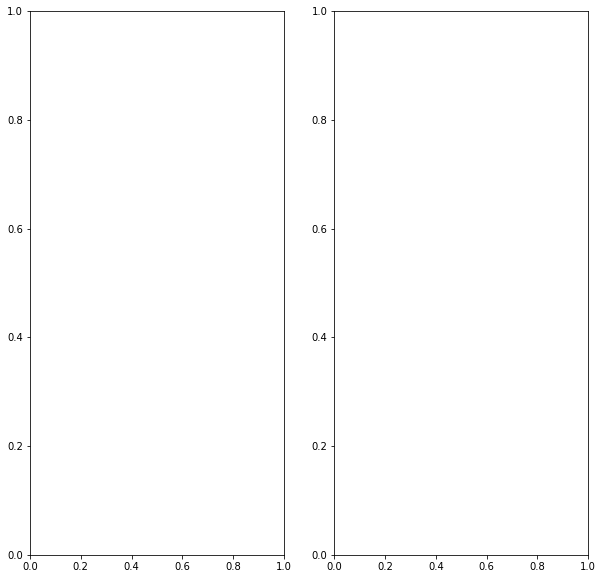

In [13]:
# Plot the grid

# Identify the best model(s)

colors = ['magenta', 'green', 'cyan','yellow','blue', 'red','orange']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid

fig, axes = pl.subplots(nrows=1, ncols=2,figsize=(10,10))
n_plot = 0
for i in np.arange(2):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]
    
    # Plot chi2 map

    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))
    
    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s / 2., 
            np.max(grid_log_s[index_logs]) + delta_log_s / 2.,
            np.min(grid_log_q) - delta_log_q/ 2., 
            np.max(grid_log_q) / 2.],
        cmap='viridis', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')

pl.show()

In [ ]:
print(fit_planet_event.model.parameters.t_E)

In [17]:
def make_grid_model(index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.
    
    index = index of the grid point for which to generate the model
    """
    model = mm.Model({
        't_0': fit_planet_event.model.parameters.t_0, 
        'u_0': fit_planet_event.model.parameters.u_0 ,
        't_E': fit_planet_event.model.parameters.t_E,
        'rho': grid[4, index],
        's': 10.**grid[0, index],
        'q': 10.**grid[1, index],
        'alpha': grid[3, index]})
    model.set_magnification_methods(magnification_methods)
    return model

In [18]:
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)

best_fit_event = mm.Event(datasets=[H_data,K_data], model=best_fit_model)

Best Models
    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2458654.00000  0.030000    50.0000 0.00000   1.00000   1.00000000     0.00000 



In [16]:
# Plot the best-fit model
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)

best_fit_event = mm.Event(datasets=[H_data,K_data], model=best_fit_model)
#(f_source, f_blend) = best_fit_event.get_ref_fluxes(fit_blending = True)

# # Whole model
# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]
pl.figure(figsize=(10,10))
best_fit_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black')
best_fit_event.plot_data(subtract_2450000=True)
pl.title(filename + ' Grid model ')
#pl.savefig(filename + '_grid_model', dpi=100)
pl.show()

# Zoom of planet
# Best model = black
pl.figure(figsize=(10,10))
best_fit_event.plot_model(subtract_2450000=True, color='black',label='best',zorder=10)
best_fit_event.plot_data(subtract_2450000=True, s=5, zorder=10)
pl.xlim(8600,8725)
pl.title(filename + ' grid model zoom')
#pl.savefig(filename + '_grid_model_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
best_fit_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.2,.2)
pl.title(filename + ' grid model residuals')
#pl.savefig(filename + '_grid_model_res', dpi=100)
pl.show()

# Other models (color-coding matches grid)
for j, index in enumerate(index_sorted[1:n_best]):
    model = make_grid_model(index)
    pl.figure(figsize=(10,10))
    model.plot_lc( f_source=f_source, f_blend=f_blend,
        subtract_2450000=True, color=colors[j - 1], lw=2)
    best_fit_event.plot_data(subtract_2450000=True, s=10, zorder=0,marker_list = 'o',markerfacecolor='none')
    pl.title('{0} best models'.format(n_best))
    pl.xlim(8640,8685)
    pl.legend(loc='best')
    pl.show()
    print(model)
    

for j, index in enumerate(index_sorted[1:n_best]):
    model.plot_trajectory(color='blue', caustics=True)
    #pl.xlim(-.05,.3)
    #pl.ylim(-.10,.10)    
    pl.show()


Best Models
    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2458654.00000  0.030000    50.0000 0.00000   1.00000   1.00000000     0.00000 



LinAlgError: SVD did not converge in Linear Least Squares

<Figure size 720x720 with 0 Axes>

In [ ]:

# Refine the n_best minima to get the best-fit solution
parameters_to_fit = ['t_0', 'u_0', 't_E', 'rho', 'alpha', 's', 'q'] #mcmc

fits = []
for index in index_sorted[:n_best]:
    model = make_grid_model(index)
    event = mm.Event(datasets=[H_data,K_data], model=model)
    print(event.model)
    result = fit_model( 
        event, parameters_to_fit=parameters_to_fit)
    fits.append([result.fun, result.x])
    print(result)

In [ ]:
# Plot the best-fit model and output the parameters

# Extract best fit
chi2 = [x[0] for x in fits]
fit_parameters = [x[1] for x in fits]
index_best = np.argmin(chi2)

# Setup the model and event
parameters = {}
for i, parameter in enumerate(parameters_to_fit):
    parameters[parameter] = fit_parameters[index_best][i]
    
final_model = mm.Model(parameters)
final_model.set_magnification_methods(magnification_methods)
final_event = mm.Event(datasets=[H_data,K_data], model=final_model)
print(final_event.model)
print('chi2: {0}'.format(final_event.get_chi2()))

# t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
#                  best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]

# # Plot the whole light curve
pl.figure(figsize=(10,10))
final_event.plot_data(subtract_2450000=True)
final_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black', zorder=10)
pl.title(filename + ' final model ')
pl.savefig(filename + 'final_model', dpi=100)
pl.show()

# Plot zoom of the planet
pl.figure(figsize=(10,10))
final_event.plot_data(subtract_2450000=True,marker_list = 'o',markerfacecolor='none',s =10)
final_event.plot_model(t_range = [2457900,2458800],subtract_2450000=True, color='black', zorder=10)
pl.xlim(8600,8725)
pl.title(filename + ' final model zoom')
pl.savefig(filename + '_psf_zoom', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
final_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.xlim(8600,8725)
pl.ylim(-.15,.15)
pl.title(filename + ' final model residuals')
pl.savefig(filename + '_spf_model', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
final_event.plot_trajectory(color='blue', caustics=True)
pl.title(filename + ' final model caustic')
pl.savefig(filename + '_PSF', dpi=100)
pl.show()

In [ ]:
# Define the model
mixed_model = mm.Model({
    't_0': 2458653.39751, 
    'u_0': 0.036777,
    't_E': 47.4999,
    'rho': 0.01157 ,
    's':  1.31630, #effects the shape of the causitc # previous guess 1.06086
    'q': 0.01230384 ,
    'alpha': -9.63407 })
mixed_model.set_magnification_methods(magnification_methods)
mixed_event = mm.Event(datasets=[H_data,K_data], model=mixed_model)

print('chi2: {0}'.format(mixed_event.get_chi2()))

# Plot the model light curve
pl.figure(figsize=(10,10))
mixed_event.plot_data(subtract_2450000=True, color_list=['cyan', 'red'],label_list= ['H_band','K_band'],  s=10,marker_list = 'o',markerfacecolor='none')
mixed_event.plot_model(t_range=[2457900,2458800], subtract_2450000=True, color='black')
#pl.xlim(8600,8800)
pl.title(filename + ' New model')
#pl.savefig(filename + '_new_model', dpi=100)
pl.show()

pl.figure(figsize=(10,10))
mixed_event.plot_data(subtract_2450000=True, color_list=['cyan', 'red'],label_list= ['H_band','K_band'],  s=10,marker_list = 'o',markerfacecolor='none')
mixed_event.plot_model(t_range=[2458575,2458800], subtract_2450000=True, color='black')
pl.xlim(8600,8725)
pl.title(filename + ' New model zoom')
#pl.savefig(filename + '_new_model_zoom', dpi=100)
pl.show

pl.figure(figsize=(10,10))
mixed_event.plot_residuals(show_errorbars=True,subtract_2450000=True)
pl.title(filename + ' new model residuals')
pl.xlim(8600,8725)
pl.ylim(-.25,.2)
#pl.savefig(filename + '_new_model_res', dpi=100)
pl.show()

#Plot the trajectory of the source relative to the caustics
pl.figure(figsize=(10,10))
mixed_event.model.plot_trajectory(color='black', caustics=True)
#pl.xlim(-.1,.25)
#pl.ylim(-.2,.2)
pl.title(filename + ' new model caustic')
#pl.savefig(filename + '_new_model_caustic', dpi=100)
pl.show()

In [ ]:
# *Define the grid*
new_delta_log_s = 0.003
new_delta_log_q = 0.02
# grid_log_s = np.hstack(
#     (np.arange(
#         np.log10(s_minus) - 0.1, np.log10(s_minus) + 0.1, delta_log_s),
#     np.arange(
#         np.log10(s_plus) - 0.1, np.log10(s_plus) + 0.1, delta_log_s)))
new_grid_log_s = np.arange(np.log10(0.8000),np.log10(1.32),new_delta_log_s)
new_grid_log_q = np.arange(-3, -1, new_delta_log_q)

print(new_grid_log_s)
print(new_grid_log_q)

In [ ]:
new_alpha = -9.67169

# For each grid point, fit for rho, alpha
new_grid = np.empty((8, len(new_grid_log_s) * len(new_grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7} {5:>7} {6:>7} {7:>7}'.format('chi2', 's', 'q', 'alpha', 'rho','t_0','u_0','t_E'))
for new_log_s in new_grid_log_s:
    for log_q in new_grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = new_alpha + 180.
        else:
            alpha = new_alpha
            
        # Define the Model and Event
        new_planet_model = mm.Model({
            't_0': mixed_event.model.parameters.t_0, 
            'u_0': mixed_event.model.parameters.u_0,
            't_E': mixed_event.model.parameters.t_E,
            'rho': mixed_event.model.parameters.rho,
            's': 10.**new_log_s,
            'q': 10.**new_log_q,
            'alpha': alpha})
        new_planet_model.set_magnification_methods(magnification_methods)
        new_planet_event = mm.Event(datasets = [H_data,K_data], model=new_planet_model)
            
        # Fit the Event
        result = fit_model(new_planet_event, parameters_to_fit=['rho', 'alpha','t_0','u_0','t_E'])
        if result.success:
            chi2 = new_planet_event.get_chi2()
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f} {5:7.5f} {6:7.2f} {7:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            new_planet_event.model.parameters.alpha, new_planet_event.model.parameters.rho,
            new_planet_event.model.parameters.t_0,new_planet_event.model.parameters.u_0,
            new_planet_event.model.parameters.t_E))
        
        new_grid[0, i] = new_log_s
        new_grid[1, i] = new_log_q
        new_grid[2, i] = chi2
        new_grid[3, i] = new_planet_event.model.parameters.alpha.value
        new_grid[4, i] = new_planet_event.model.parameters.rho
        new_grid[5, i] = new_planet_event.model.parameters.t_0
        new_grid[6, i] = new_planet_event.model.parameters.u_0
        new_grid[7, i] = new_planet_event.model.parameters.t_E
            
        i += 1

In [ ]:
# Plot the grid

# Identify the best model(s)
new_best = np.argmin(np.array(new_grid[2,:]))
new_sorted = np.argsort(np.array(new_grid[2,:]))
n_best = 8 
colors = ['magenta', 'green', 'cyan','yellow','blue', 'red','orange']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid

fig, axes = pl.subplots(nrows=1, ncols=2,figsize=(10,10))
n_plot = 0
for i in np.arange(2):
    if i == 0:
        new_logs = np.where(new_grid_log_s < 0.)[0]
        new_grid = np.where(new_grid[0, :] < 0.)[0]
    else:
        new_logs = np.where(new_grid_log_s >= 0.)[0]
        new_grid = np.where(new_grid[0, :] >= 0.)[0]
    
    # Plot chi2 map

    chi2 = np.transpose(
            new_grid[2, new_grid].reshape(len(new_logs), len(new_grid_log_q)))
    
    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(new_grid_log_s[new_logs]) - new_delta_log_s / 2., 
            np.max(new_grid_log_s[new_logs]) + new_delta_log_s / 2.,
            np.min(new_grid_log_q) - delta_log_q/ 2., 
            np.max(new_grid_log_q) / 2.],
        cmap='viridis', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(new_grid[2,np.isfinite(new_grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if new_best in index_grid:
        axes[i].scatter(new_grid[0, index_best], new_grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(new_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(new_grid[0, index], new_grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')

pl.show()

In [ ]:
print(grid[2,:])

In [ ]:

# Identify the best model(s)
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))
n_best = 8 
colors = ['magenta', 'green', 'cyan','yellow','blue', 'red','orange']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid

fig, axes = pl.subplots(nrows=1, ncols=2,figsize=(10,10))
n_plot = 0
for i in np.arange(2):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]
    
    # Plot chi2 map

    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))
    
    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s / 2., 
            np.max(grid_log_s[index_logs]) + delta_log_s / 2.,
            np.min(grid_log_q) - delta_log_q/ 2., 
            np.max(grid_log_q) / 2.],
        cmap='viridis', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')

pl.show()